In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import random 
import time
import scipy.integrate as integrate
import pandas as pd 

In [2]:
ua = 149597870
ang_km = 1*10**-13
ano = 365*24*3600
mu0 = 1.256637061 * 10 ** -6 #N A**-2
ep0 = 8.854187817 * 10 **(-12) #C**2 N**-1 m**-2
c = 1/(mu0*ep0)**(1/2)
print (c)

299792458.06250066


In [3]:
sor = input('Você deseja utilizar o SORA? 1 - SIM 2 - NÃO')
if sor=='1':
   # from sora.body import Body
   # from sora import EphemHorizons
    from sora import Star
    from sora import LightCurve # C:\Users\Wellington\anaconda3\Lib\site-packages\sora
else:
    print('a')
    #inserir funções similares as do SORA

SORA version: 0.2.1


# Definindo funções usadas no programa

In [4]:
Cn2 = 1 

In [5]:
def calculo_magnitude(magnitude_absoluta, distancia): #em UA
    magnitude_aparente = magnitude_absoluta + 5*np.log10(distancia*(distancia-1))
    return(magnitude_aparente)

In [52]:
def Fluxo_lambda(magnitude):
    Fuxo=(10**(2.5*np.log10(3.44*(10**-12)))+(magnitude))**(1/2.5) #usando equação 20.9 kepler
    Fluxo = (3.69*10**-9)*(10**(magnitude))**(-1/2.5)
    return (Fluxo) #W/m2
# F V=0 3.44 * 10 ** - 8 J /m**2 s**-1 um**-1 === 1000 fotons cm**-2 s**-2 um**-1
#FLuxo 
print(Fluxo_lambda(0)) #W/m²

def Flux_lambda_ruido(magnitude):
    Fluxo=Fluxo_lambda(magnitude)
    tempo = 1
    area = 1
    cn15=integrate.quad(Cn22,0,np.inf)
    ir_saha=19.2*(600*10**-9)**(-7/6)*cn15[1]
    E0 = 3.6*10**-9 #W/m²
    E = (E0*10**(-0.4*magnitude))/tempo/area #W/cm²
    return(np.exp((np.log(E)+np.random.normal(0,ir_saha**(1/2)/area)*tempo)))
print(Flux_lambda_ruido(0))

3.6900000000000003e-09
3.5834581983999223e-09


In [53]:
print(ir_saha)

NameError: name 'ir_saha' is not defined

In [54]:
def fluxo_fotons(fluxo, lamb):
    h = 6.626196*10**-34 #m2kg/s
    c = 2.997924562*10**8 #m/s
    angstrons_m = 10**(-10) #
    fotons=fluxo*(lamb*angstrons_m)/(h*c)
    return(fotons)
print(fluxo_fotons(Fluxo_lambda(0),5500)/10**4)
print(10**6)
#fotons /m²/s

1021654.5590701991
1000000


In [55]:
def diametro_angular(diametro, distancia): #unidades
    diametro_ang=(np.arctan(diametro/(distancia*ua)))*(360/(2*np.pi))*3600*1000
    return(diametro_ang) #segundo de arco

In [56]:
def Escala_placa(pixel, bin, dist_focal): #unidades
    escala_placa = 206265*pixel*bin/(1000*dist_focal)
    return escala_placa #segundo de arco/pixel

In [57]:
def tamanho_angular_corpo(diametro_angular,Escala_placa):
    tamanho = diametro_angular/Escala_placa
    return tamanho

In [58]:
ep = Escala_placa(5.86,1,100)
da = diametro_angular(6400,40)
print(tamanho_angular_corpo(da,ep))

18.2514153568502


In [59]:
#Incerteza de um photon-counting device que segue Estatistica de Poisson é sqrt(N), sendo N o número de fotons contados ToMeasuretheSky p.239


In [60]:
def soma_magnitude(mag1, mag2):
    magnitude_total = -2.5*np.log10(10**(-0.4*mag1)+10**(-0.4*mag2))
    return(magnitude_total)
    #https://www.astro.keele.ac.uk/jkt/pubs/JKTeq-fluxsum.pdf

print(soma_magnitude(21,20))


19.636148842226767


In [61]:
def fresnel_scale(lamb,dist):
    lamb = lamb*(10**-10)*micrometer_km
    dlamb = lamb*0.001
    dist = dist*ua
    fresnel_scale_1 = calc_fresnel(dist, lamb-dlamb/2.0)
    fresnel_scale_2 = calc_fresnel(dist, lamb+dlamb/2.0)
    fresnel_scale = (fresnel_scale_1 + fresnel_scale_2)/2.0
    return fresnel_scale



# https://www.youtube.com/watch?v=Bi2JWAHhBNg
def calc_fresnel(distance, bandpass):
    """Calculates the Fresnel scale.

    Fresnel Scale = square root of half the multiplication of wavelength and
    object distance.

    Parameters
    ----------
    distance : `int`, `float` array
        Distances, in km.

    bandpass : `int`, `float`, array
        Wavelength, in km.

    Returns
    -------
    fresnel_scale : `float`, array
        Fresnel scale, in km.
    """
    bandpass = bandpass*ang_km
    distance = distance*ua
    return np.sqrt(bandpass * distance / 2)


def bar_fresnel(X, X01, X02, opacity,distance,bandpass):
    """Returns the modelled light curve considering fresnel diffraction.

    Parameters
    ----------
    X : array
        Array with time values converted in km using the event velocity.

    X01 : `int`, `float`
        Immersion time converted in km using the event velocity.

    X02 `int`, `float`
        Emersion time converted in km using the event velocity.

    fresnel_scale : `int`, `float`
        Fresnel scale, in km.

    opacity : `int`, `float`
        Opacity. Opaque = 1.0, transparent = 0.0.

    Returns
    -------
    flux_fresnel : array
        The light curve with fresnel diffraction.
    """
    import scipy.special as scsp

    # Converting from km to units of fresnel scale
    fresnel_scale = calc_fresnel(distance,bandpass)
    x = X / fresnel_scale
    x01 = X01 / fresnel_scale
    x02 = X02 / fresnel_scale
    # Fresnel diffraction parameters
    x1 = x - x01
    x2 = x - x02
    s1, c1 = scsp.fresnel(x1)
    s2, c2 = scsp.fresnel(x2)
    cc = c1 - c2
    ss = s1 - s2
    r_ampli = - (cc + ss) * (opacity / 2.)
    i_ampli = (cc - ss) * (opacity / 2.)
    # Determining the flux considering fresnel diffraction
    flux_fresnel = (1.0 + r_ampli) ** 2 + i_ampli ** 2
    return flux_fresnel


In [62]:
if self.d_star > 0:
# Computing fresnel diffraction for the case where the star size is not negligenciable
    resolucao = (self.d_star/2)/npt_star
    flux_star_1 = np.zeros(len(time_model))
    flux_star_2 = np.zeros(len(time_model))
            # Computing stellar diameter only near the immersion or emersion times
    star_diam = (np.absolute(x - x01) < 3*self.d_star) + (np.absolute(x - x02) < 3*self.d_star)
    p = np.arange(-npt_star, npt_star)*resolucao
    coeff = np.sqrt(np.absolute((self.d_star/2)**2 - p**2))
    for ii in np.where(star_diam == True)[0]:
        xx = x[ii] + p
        flux1 = bar_fresnel(xx, x01, x02, fresnel_scale_1, opacity)
        flux2 = bar_fresnel(xx, x01, x02, fresnel_scale_2, opacity)
        flux_star_1[ii] = np.sum(coeff*flux1)/coeff.sum()
        flux_star_2[ii] = np.sum(coeff*flux2)/coeff.sum()
        flux_star[ii] = (flux_star_1[ii] + flux_star_2[ii])/2.
flux_inst = np.zeros(len(time_obs))

NameError: name 'self' is not defined

In [63]:
def ka(band):
    k=2*np.pi/band
    return k

In [77]:
#band = 6000 *10**-9

#print(k)
#L=20000
#diam_teles=1.6


In [72]:
aaf = (1+1.07*(((k*(diam_teles/100))**2)/(4*L))**(7/6))**(-1)

In [66]:
#mag_star = 21
#mag_obj = 20
#queda = (mag_star-mag_obj) + 2.5 * (np.log10(10**((mag_star-mag_obj)/2.5)+1))
#ou
#queda2 = 2.5*(np.log10(10**(mag_obj-mag_star)/2.5)+1)
#print(queda)
#print(queda2)

#fluxo_estrela = 10**(mag_star/2.5)
#fluxo_obj = 10**(mag_obj/2.5)
#dif_mag1 = -2.5 * np.log10(fluxo_estrela/fluxo_obj) + 2.5 * np.log10((fluxo_estrela + fluxo_obj) / fluxo_obj)
#dif_mag2 = 2.5 * np.log10((fluxo_estrela + fluxo_obj) / fluxo_estrela)
#print(dif_mag1)
#print(dif_mag2)
	
#aux = (mag_star-mag_obj) * 0.4
#contraste
#contr = 1 / (10**(aux)+1)
#soma_mag = mag_star - (2.5*(np.log10(1/contr)))
#queda_mag = mag_obj - mag_star
#aux = (soma_mag - mag_obj) * 0.4
#botton_flux = 10**(aux)
#print(soma_mag)
#print(queda_mag)
#print(aux)
#print(botton_flux)

In [20]:
#def Fluxo_de_fotons_Observado:
#    Fluxo_observado=*integral*fluxo_fotons*transmissao_atmosferica*eficiencia_telescopio*eficiencia_instrumento*eficiencia_filtro*eficiencia_detector*dlambda
#    Fluxo_deFotons_observado=Area_telescopio*tempo_integracao*Fluxo_observado

In [21]:
#numero de bits da câmera, limita o numero máximo de contagem que a ccd pode obter ...
#ADU = 2^numero de bits-1
#Ganho X eletrons por ADU resultando na capacidade total de pixels da ccd

In [22]:
#ARRUMAR para latitude
def posicao_corda(diametro_objeto, latitude):
    corda_corpo = diametro_objeto*np.cos(latitude)
    inicio = -corda_corpo/2
    fim = corda_corpo/2
    return(corda_corpo)

In [23]:

#ti = 0.1
#k = 2*np.pi/(5500*10**-10)
#L = 1
#area_teles = area_telescopio/10000
#f = Fluxo_lambda(0)
#var_log_amplitude = 0.124* (k/10) ** (7/6) * (L) ** (11/6) * Cn2 #tyson 2.31 
#aaf = (1+1.07*((k*(4*(area_teles)/(np.pi)))/(4*L))**(7/6))**(-1)
#var_irradi = aaf * (np.exp(4 * (var_log_amplitude))-1) #2.33
#ira = (np.random.normal(0,var_irradi**(1/2)))
#print("Fluxo")
#print(f)
#print("var_log")
#print(var_log_amplitude**(1/2))
#print("var ampli 10")
#print(np.log10(var_log_amplitude))
#print("var ampli e")
#print(np.log(var_log_amplitude))
#print("var_irradi")
#print(var_irradi)
#print("Ira")
#print(ira)
#ir = f+(ira)
#print("ir")
#print(ir)
#n_fotons = fluxo_fotons(ir,5500)*area_teles
#print("n_fotons")
#print(n_fotons)
#print("fotons")
#print(fluxo_fotons(f,5500)*area_teles)
#print((4*10**6)*10**(0/2.5)*10**4)
#print(fluxo_fotons(f,6500)*area_teles)

In [73]:
def Cnh2(h):
    Cn2 = A * np.exp(-h/Ha) + B * np.exp(-h/Hb) + C * (h**(10)) * np.exp(-h/Hc) + D *np.exp((-(h-Hd)**2)/2*d*d)
    cn2=Cn2
    return cn2
def Cn22(h):
    Cn2 = A * np.exp(-h/Ha) + B * np.exp(-h/Hb) + C * (h**(10)) * np.exp(-h/Hc) + D *np.exp((-(h-Hd)**2)/2*d*d)
    cn2=Cn2*h**(5/6)
    return cn2
def Cn22h(h):
    Cn2h = A * np.exp(-h/Ha) + B * np.exp(-h/Hb) + C * (h**(10)) * np.exp(-h/Hc) + D *np.exp((-(h-Hd)**2)/2*d*d)
    cn2h = Cn2h*h**(5/3)
    return cn2h

In [74]:
#print(var_log_amplitude)
##var_log = integrate.quad(Cn22,0,20000)
#intensity = 19.2*banda**(-7/6)
#print(var_log[0]*intensity)

In [78]:
############ FASE OK
#f = Fluxo_lambda(18)
#banda = 5000
#area_telescopio = np.pi*30**2 #CM²
#ti = 1
#g=fluxo_fotons(f,banda)*area_telescopio
#maxim=0

def erro_fase(f,var_fase):
    factor = 1
    #n_fotons = fluxo_fotons(f,banda)*area_telescopio*ti
    if f > 20000:
        factor= f / 20000
        f = 20000
        #print("Por questão de tempo coomputacional será realizada uma aproximação no número de fótons")
    x = f/2
    if f < 1:
        factor = 2
        f = 1
    desv_pad_fase = var_fase**(1/2)
    total = 0
    

    maxim = np.arange(0,x,factor)
   # print(maxim)
    if maxim ==[0]:
        return 0
    for i in (maxim):
        j1 = (np.sin(np.random.normal(0, desv_pad_fase)))
        j2 = (np.sin(np.random.normal(0, desv_pad_fase)))
        if j1+j2 > 0.5 or j1+j2 <-0.5:
            total += 2
        else:
            total = total

    return total*factor
#erro_fase(g,5000)    
#print(int(sum(arranjo)))
#print(int(np.random.normal(n_fotons, var_fase**(1/2))))
#for i in arranjo:
#    if arranjo[i] + arranjo [i+1] > 0.5 or arranjo[i] + arranjo[i+1] < -0.5:
#        total = total+2
#    i = i+2
#print(total*factor)


In [79]:
var_fase

NameError: name 'var_fase' is not defined

In [80]:
print(erro_fase(10**-15,var_fase))

NameError: name 'var_fase' is not defined

In [81]:
def contagem_fluxo(tempo_atual, mag_obj, mag_star, area_telescopio
, tempo_exposicao, banda, inicio, fim):
   # mag_star = mag_star #combinar com mag obj
    
   #
    ti = tempo_exposicao/100
    t = 0
    fluxo_total = 0
    while t < tempo_exposicao:
        #verifica posição objeto
        posicao = tempo_atual
        if posicao >= inicio and posicao <= fim:
            magnitude = mag_obj
           # print("dentro if 1")
        else:
            magnitude = soma_magnitude(mag_star,mag_obj)
           # print("dentro else 1")
        f = Fluxo_lambda(magnitude)
       # print(f)
        #var_log_amplitude = 0.307* k ** (7/6) * L ** (11/6) * Cn2 #tyson 2.31 
        #aaf = (1+1.07*(k*(area_telescopio/(4*np.pi))/(4*L))**(7/6))**(-1)
        #var_irradi = aaf * (np.exp(4 * (var_log_amplitude))-1) #2.33
        #ira = (np.random.normal(0,var_irradi**(1/2)))*ti
        #ir = f+abs(ira)
        n_fotons = fluxo_fotons(f,banda)*area_telescopio*ti 
       # print(n_fotons)
      #  photons = np.random.poisson(ruido_termico(270,n_fotons,ti))
        #arranjo = list()
        #for i in ((np.arange(0,n_fotons,1))):
        #    arranjo.append(1)
        #p=0
        #for i in arranjo:
        #    fase = (np.random.normal(0, var_fase**(1/2)))
        #    j = ((i/i+np.sin(fase)))    
        #    arranjo[p] = j
        #    p+=1
        f = Flux_lambda_ruido(magnitude,area_telescopio)
        #print(f)
        #f = Fluxo_lambda(magnitude)
        fluxo_total=f
        #fluxo_total += np.random.normal(fluxo_fotons(f,banda),var_irradi**(1/2))*area_telescopio*ti #+ fluxo_fotons(f, banda)*ti#*area_telescopio
        #fluxo_total = fluxo_total#/2 
        
        if fluxo_total < 0:
            fluxo_total = 0 #abs(fluxo_total)
        fluxo_total = fluxo_fotons(fluxo_total,banda)
        t += ti
        tempo_atual += ti
    return(fluxo_total)

        #fluxo_total += n_fotons #+ int(sum(arranjo))*ti  #fluxo_fotons(f, banda)*area_telescopio*ti
        #t += ti
        #tempo_atual += ti
       #
       #  print(fluxo_total)
    #### INSERIR O NUMERO DE FÓTONS E O TEMPO EM UMA TABELA
    #return(int(fluxo_total))


In [82]:
def contagem_fluxo_anel(tempo_atual, mag_obj, mag_star, area_telescopio
, tempo_exposicao, banda, inicio, fim, prof_otica, inicio_anel1, fim_anel1
,inicio_anel2, fim_anel2):
   # mag_star = mag_star #combinar com mag obj
    
   #
    ti = tempo_exposicao/20
    t = 0
    fluxo_total = 0
    while t < tempo_exposicao:
        #verifica posição objeto
        posicao = tempo_atual
        if posicao >= inicio and posicao <= fim:
            magnitude = mag_obj
        elif posicao >= inicio_anel1 and posicao <= fim_anel1:
            magnitude = soma_magnitude((mag_star+mag_star * prof_otica), mag_obj) 
        elif posicao >= inicio_anel2 and posicao <= fim_anel2:
            magnitude = soma_magnitude(mag_obj, (mag_star+mag_star*prof_otica))
        else:
            magnitude = soma_magnitude(mag_star,mag_obj)
        f = Fluxo_lambda(magnitude)
        fluxo_total += fluxo_fotons(f, banda)*area_telescopio*ti
        t += ti
        tempo_atual += ti
    return(fluxo_total)

In [83]:
def contagem_fluxo_anel_satelite(tempo_atual, mag_obj, mag_star,mag_sat, area_telescopio
, tempo_exposicao, banda, inicio, fim, prof_otica, inicio_anel1, fim_anel1
,inicio_anel2, fim_anel2,inicio_sat,fim_sat):
   # mag_star = mag_star #combinar com mag obj
    mag_anel = mag_star-2.5*np.log(np.exp(-prof_otica))
   #
    ti = tempo_exposicao/100
    t = 0
    fluxo_total = 0
    while t < tempo_exposicao:
        #verifica posição objeto
        posicao = tempo_atual
        if posicao >= inicio and posicao <= fim:
            magnitude = soma_magnitude(mag_obj,mag_sat)
        elif posicao >= inicio_anel1 and posicao <= fim_anel1:
            magnitude1 = soma_magnitude(mag_sat,mag_obj)
            magnitude = soma_magnitude((mag_anel), magnitude1) 
        elif posicao >= inicio_anel2 and posicao <= fim_anel2:
            magnitude1 = soma_magnitude(mag_sat,mag_obj)
            magnitude = soma_magnitude(magnitude1, mag_anel)
        elif posicao >= inicio_sat and posicao <= fim_sat:
            magnitude = soma_magnitude(mag_sat, mag_obj) 
        else:
            magnitude1 = soma_magnitude(mag_star,mag_obj)
            magnitude = soma_magnitude(magnitude1,mag_sat)
        f = Flux_lambda_ruido(magnitude)
        #f = Fluxo_lambda(magnitude)
        fluxo_total=f
         #+ fluxo_fotons(f, banda)*ti
        #fluxo_total = fluxo_total#/2 
        
        if fluxo_total < 0:
            fluxo_total = 0 #abs(fluxo_total)
        fluxo_total == fluxo_fotons(fluxo_total,banda)*ti*area_telescopio
        #fluxo_total += fluxo_total*np.random.normal(fluxo_total,var_irradi**(1/2))
        t += ti
        tempo_atual += ti
    return(fluxo_total)

In [84]:
def contagem_fluxo_satelite(tempo_atual, mag_obj, mag_star, mag_sat, area_telescopio
, tempo_exposicao, banda, inicio, fim, inicio_sat, fim_sat):
   # mag_star = mag_star #combinar com mag obj
    
   #
    ti = tempo_exposicao/20
    t = 0
    fluxo_total = 0
    while t < tempo_exposicao:
        #verifica posição objeto
        posicao = tempo_atual
        if posicao >= inicio and posicao <= fim:
            magnitude = soma_magnitude(mag_sat, mag_obj)
        elif posicao >= inicio_sat and posicao <= fim_sat:
            magnitude = soma_magnitude(mag_sat, mag_obj) 
        else:
            magnitude1 = soma_magnitude(mag_star,mag_obj)
            magnitude = soma_magnitude(mag_sat,magnitude1)
        f = Fluxo_lambda(magnitude)
        fluxo_total += fluxo_fotons(f, banda)*ti*area_telescopio
        t += ti
        tempo_atual += ti
    return(fluxo_total)

In [85]:
def contagem_fluxo_ceu(tempo_atual, area_telescopio, tempo_exposicao, banda, inicio, fim):
   # mag_star = mag_star #combinar com mag obj
    ti = tempo_exposicao/20
    t = 0
    fluxo_total = 0
    while t < tempo_exposicao:
        #verifica posição objeto
        if banda < 4050 and banda >= 2000: #3700
            magnitude = 23.2
        if banda >= 4050 and banda < 4950: #4400
            magnitude = 23.4
        if banda >= 4950 and banda < 5950: #5500
            magnitude = 22.7
        if banda >= 5950 and banda < 7200: #6400 
            magnitude = 22.2
        if banda >= 7200 and banda < 10000: #8000
            magnitude = 22.2
        if banda >= 10000 and banda < 14000: #12000
            magnitude = 20.7
        if banda >= 14000 and banda < 19000: #16000
            magnitude = 20.9
        if banda >= 19000 and banda < 25000: #22000
            magnitude = 21.3
        f = Fluxo_lambda(magnitude)
        fluxo_total += fluxo_fotons(f, banda)*area_telescopio*ti
        t += ti
        tempo_atual += ti
    return(fluxo_total)

In [86]:
#S/N
def signalNoise():
    N = 1#numero de fótons coletados
    npix = 1 #numero de pixels levados em consideração para o S/N 
    Ns = 1 #Número de fótons por pixel do fundo de céu
    Nd = 1 #Número de eletrons de dark current 
    Nr = 1 #Número de eletrons por pixel resultante do ruido de leitura
    return N


In [87]:
#cintilação

def cintilacao(velocidade_vento_chao, altitude, tempo):
   
    result,error = integrate.quad(vel_vento, 5000, 20000, args=(altitude, velocidade_vento_chao))
    
    w=1/15*result
    A=np.exp(random.gauss(altitude, tempo))
    print("O resultado de A é " + str(A))
    cintila = A*(2.2*10**(-53)*(altitude**10)*(w/27)**2*np.exp(-altitude/1000)+1*10**-16*np.exp(-altitude/1500))
    return cintila
####

In [372]:
####seeing 17_08
#tabela 3.1 hardy para referencia dos números
seeing = 2.5#(1.22*500*10**-9)/0.05
h = 4213 
L_prop = 20000 #m
dist_raios = 10 # distancia entre dois raios paralelos que passam pela atmosfera e geram uma diferença de fase deltafi
L=20000
if seeing >= 1.88:
    seeing = 2.5
    print("O valor do seeing utilizado será de {:.2f} para se adaptar ao modelo de turbulência" .format(seeing))
    A = 17 * 10 ** -15
    Ha = 100
    B = 27 * 10 ** -17
    Hb = 1500
    C = 3.59 * 10 ** -53 
    Hc = 1000
    D = 0
    Hd = 0
    r0 = 0.05
elif seeing < 1.88 and seeing >= 1.205:
    seeing = 1.26
    print("O valor do seeing utilizado será de {:.2f} para se adaptar ao modelo de turbulência" .format(seeing))
    A = 4.5 * 10 ** -15
    Ha = 100
    B = 9 * 10 ** -17
    Hb = 1500
    C = 2 * 10 ** -53 
    Hc = 1000
    D = 0
    Hd = 0
    r0 = 0.1
elif seeing < 1.205 and seeing >= 0.995:
    seeing = 1.15
    print("O valor do seeing utilizado será de {:.2f} para se adaptar ao modelo de turbulência" .format(seeing))
    A = 0
    Ha = 1
    B = 27 * 10 ** -17
    Hb = 1500
    C = 5.94 * 10 ** -53 
    Hc = 1000
    D = 0
    Hd = 0
    r0 = 0.11
elif seeing < 0.995 and seeing >= 0.685:
    seeing = 0.84
    print("O valor do seeing utilizado será de {:.2f} para se adaptar ao modelo de turbulência" .format(seeing))
    A = 2 * 10 ** -15
    Ha = 100
    B = 7 * 10 ** -17
    Hb = 1500
    C = 1.54 * 10 ** -53 
    Hc = 1000
    D = 0
    Hd = 0
    r0 = 0.15
elif seeing < 0.685 and seeing >= 0.445:
    seeing = 0.53
    print("O valor do seeing utilizado será de {:.2f} para se adaptar ao modelo de turbulência" .format(seeing))
    A = 0
    Ha = 1
    B = 1 * 10 ** -17
    Hb = 3000
    C = 1.63 * 10 ** -53 
    Hc = 1000
    D = 1
    Hd = 6500
    r0 = 0.24
elif seeing < 0.445:
    seeing = 0.36
    print("O valor do seeing utilizado será de {:.2f} para se adaptar ao modelo de turbulência" .format(seeing))
    A = 0
    Ha = 1
    B = 1 * 10 ** -17
    Hb = 3000
    C = 1.63 * 10 ** -53 
    Hc = 1000
    D = 0
    Hd = 0
    r0 = 0.34
else:
    print("erro")

#k = 2 * np.pi / (0.55 * 10 **-6)

#deltafi = k*d*deltaN(d) #deltaN é a variação no indice de refração
d = ((np.pi**2)/(np.pi*np.pi*Cn2*L))**(3/5) # espessura da camada de ar responsável pelos efeitos
print(d)
Cn2 = A * np.exp(-h/Ha) + B * np.exp(-h/Hb) + C * (h**(10)) * np.exp(-h/Hc) + D *np.exp((-(h-Hd)**2)/2*dist_raios*dist_raios)
cn10 = integrate.quad(Cnh2,-np.inf,np.inf)
cn11=integrate.quad(Cn22,0,np.inf)
cn12=integrate.quad(Cn22h,-np.inf,np.inf)
#L=(cn12[0]/cn10[0])**(3/5)*100 #5.137 saha
print(Cn2)
print(L)

print(cn11[0])
print(cn10)
print(cn12)
#valido para l0<dist_raios<L0
k=ka(band)
D0 = 1.46 * k ** 2 * Cn2 * L * dist_raios **(5/3)
print(D0)
s2 = seeing *180*60*60/np.pi
print(seeing)
print(s2)

O valor do seeing utilizado será de 2.50 para se adaptar ao modelo de turbulência
29427329.65337539
1.7213145127485276e-17
20000
1.1153490078682484e-10
(2.288993476305122e-09, 4.513671925174496e-09)
(4.958052048568257e-07, 6.268723560209883e-05)
2.395996096785095e-17
2.5
515662.0156177409


c:\Users\Wellington\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:465: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagie(func,bound,infbounds,args,full_output,epsabs,epsrel,limit)
C:\Users\Wellington\AppData\Local\Temp\ipykernel_2820\2619958994.py:10: RuntimeWarning: overflow encountered in exp
  Cn2h = A * np.exp(-h/Ha) + B * np.exp(-h/Hb) + C * (h**(10)) * np.exp(-h/Hc) + D *np.exp((-(h-Hd)**2)/2*d*d)
C:\Users\Wellington\AppData\Local\Temp\ipykernel_2820\713653368.py:91: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  cn12=integrate.quad(Cn22h,-np.inf,np.inf)


In [373]:
Cn22

<function __main__.Cn22(h)>

In [374]:
# contar fotons em área equivalente ao telescopio, aplicar a variancia de fase em cada fóton e com base 
#nisso fazer dois fótons interagirem e assim incluir o ruído

In [375]:
#diam_teles = 1.6 #m
#k = 2 * np.pi/ (600*10**-9) #/m

var_fase = 0.134 * (diam_teles/r0) ** (5/3) #2.62 tyson
#var_log_amplitude = 0.124* (k ** (7/6)) * (L_prop ** (11/6) )* Cn2 #2.31 tyson

# a is an aperture-averaging factor
a = (1 + 1.07 * ((k * (diam_teles**2))/(4 * L_prop))**(7/6))**-1
#print(a)

#print(var_fase)
#print("log_amp " + str(var_log_amplitude))

cn15=integrate.quad(Cn22,0,np.inf)
ir_saha=((19.2*band*(10**-9))**(-7/6))*cn15[0]
#print("variancia log intensidade " + str(ir_saha**(1/2))) #Saha 5.139

var_irradi = a * (np.exp(4 * (ir_saha))-1)
print(var_fase)

#print(cn15)


621972.9037041129


In [376]:
erro_fase(1*10**-15,var_fase)

0

In [377]:

hp=6.62*10**-34 #m²kg/s
#mag_star = 14.83
#print(np.random.normal(0,var_fase**(1/2))) #DIVIDIR POR PI E VERIFICAR SE OCORRE INTERFERENCIA DESTRUTIVA OU CONSTRUTIVA
#print(np.random.normal(0,var_log_amplitude**(1/2)))
#tempexp = 0.44 #s
#compri_onda = 600*10**-9 #m
print(band)
print(tempexp)
ampli = (2*hp/(((band*10**-9)**2) * ep0 * tempexp))**(1/2)
print("a amplitudo vale " + str(ampli))
print(ir_saha)
amp = np.random.normal(np.log(ampli),ir_saha**(1/2))#var_log_amplitude**(1/2))
print(amp)
print(np.exp(amp))

print("A amplitude ficou: "+ str(np.exp(amp)))
#intesit = ((c*ep0*(np.exp(ampli))**2)/2)/10000/tempo
intesity = ((c*ep0*(np.exp(amp))**2)/2)/tempexp/10000 #W/cm²
E0 = 3.6*10**-9 #W/m²
E = (E0*10**(-0.4*mag_star))/tempexp/(np.pi*(diam_teles/2)**2) #W/cm²
#E2=(hp*c/compri_onda)/tempo/(np.pi*(diam_teles/2)**2) #W/cm²
print("A irradiancia é: " + str (E))
#print("A irradiancia 2 é: " + str (E2))
#print("o valor da intensidade é de " + str(intesit))
print("o valor da intensidade variada é de " + str(intesity))
ira = np.random.normal(0,(var_irradi**(1/2))/np.pi*(diam_teles/2)**2)
print("o valor da variancia da irradiancia e " + str (ira*tempexp))
irad = np.random.normal(0,(var_irradi**(1/2))/np.pi*(diam_teles/2)**2)
print("o valor da variancia da irradiancia e " + str (irad*tempexp))

print(np.exp((np.log(E)+np.random.normal(0,ir_saha**(1/2)/np.pi*(diam_teles/2)**2)*tempexp)))


6200
300
a amplitudo vale 1.1387209495971674e-07
4.224439039134849e-06
-15.985176073553896
1.1421581393150509e-07
A amplitude ficou: 1.1421581393150509e-07
A irradiancia é: 1.5351519055112095e-24
o valor da intensidade variada é de 5.7712602745666776e-24
o valor da variancia da irradiancia e -21930.051721961278
o valor da variancia da irradiancia e 15482.83336191227
inf


C:\Users\Wellington\AppData\Local\Temp\ipykernel_2820\1292063781.py:31: RuntimeWarning: overflow encountered in exp
  print(np.exp((np.log(E)+np.random.normal(0,ir_saha**(1/2)/np.pi*(diam_teles/2)**2)*tempexp)))


In [378]:
def ruido_termico(Temperatura, numero_pixel, tempo_exp):
    Eg = 1.1557 - (7.021 * 10 **(-4)*Temperatura**2/(1108+Temperatura))
    Tx = 5.86*(10**9)*(Temperatura**(2/8))*np.exp(-(Eg)/(2*(1.23*10**-4)*Temperatura)) # k = 1.23*10**-4 obtido em testes para seguir a relação da literatura
    sig_dark = (Tx*numero_pixel*tempo_exp)**(1/2)
    return sig_dark
print(np.random.poisson(ruido_termico(300,10,4)))

512


In [379]:
def ruido_leitura(ruido):
    rui_leit=np.random.normal(0,ruido)
    return rui_leit
print(ruido_leitura(2.5))

-2.351479897009445


Definindo dados

In [595]:
flua = []
vel = 30 #[30,31,32]
tmini = 0
temp = tmini
tmaxi = 4000
mag_star = 19 #magnitudes_estrelas = [12,19,21]
mag_obj = 20 #[19 20 25]
distancia = 300 #[240, 300, 520]
magi_sat = -1.25 #Triton -1.25 Miranda 3.49
mag_sat = calculo_magnitude(magi_sat, distancia)
#mag_sat = 25.1
diametro_sat = 2700 #Triton 2700 Miranda 500
distancia_sat = 60000 #Triton 60000 Miranda 250000
diametro_estrela = 1.33 #[0.98, 7.84]
diam_teles = 500 # cm
foco = 1.8 #F
ep = 0.7 #arcsec?
#ep = Escala_placa(13,1,16000)
bina = 1
gain = 0.8
readout_noise = 2.5
temperatura = 215

area_telescopio = np.pi*(diam_teles)**2 #cm²
tempexp = 0.01 #[300, 100, 50, 10, 1]
band = 6200 #[5000, 5500, 6000, 6500, 7000]
diametro_corpo = 19548 #km [18432, 19548, 20665]
centro_ocultacao =  2000 #Triton 2800 miranda 50
inicio = centro_ocultacao - diametro_corpo/vel/2
fim = centro_ocultacao + diametro_corpo/vel/2
cyc = tempexp+0.001#tempexp + 0.01
times = np.arange(tmini, tmaxi, cyc)
Xs = np.arange(tmini*vel,tmaxi*vel,cyc*vel)
X01 = inicio*vel
X02 = fim*vel
#https://arxiv.org/ftp/arxiv/papers/1805/1805.08963.pdf#:~:text=Uranus%20rings%20are%20dense%2C%20made,range%20between%200.1%20and%201.
#https://arxiv.org/pdf/1906.11728.pdf
prof_otica = 0.1 #10-4 a 0.1 (netuno) (0.003 Lassell ring), 0.1 a 1 Urano  [0.0001, 0.003, 0.1, 0.5, 1]
diametro_anel = 51000 #[40900, 53200, 51000, 42000, 37800]
espessura_anel = 10 #[2000, 100, 20, 2, 3500]
inicio_anel1 = centro_ocultacao - diametro_anel/vel/2 - espessura_anel/vel/2
fim_anel1 = centro_ocultacao - diametro_anel/vel/2 + espessura_anel/vel/2
#inicio_anel2 = centro_ocultacao + diametro_anel/vel/2 - espessura_anel/vel/2
#fim_anel2 = centro_ocultacao + diametro_anel/vel/2 + espessura_anel/vel/2
X01_an = inicio_anel1*vel
X02_an = fim_anel1*vel
#X03_an = inicio_anel2*vel
#X04_an = fim_anel2*vel
inicio_sat = centro_ocultacao - distancia_sat/vel/2 - diametro_sat/vel/2
fim_sat = centro_ocultacao - distancia_sat/vel/2 + diametro_sat/vel/2
X01_sat = inicio_sat*vel
X02_sat = fim_sat*vel
print(inicio_sat)
print(fim_sat)
print(inicio_anel1)
print(fim_anel1)
print(inicio)
print(fim)

#prof_otica = 
#print(prof_otica)
#prof_otica = -np.log(1-prof_otica)
#print(prof_otica)
#print(soma_magnitude(mag_obj, (mag_star+mag_star*prof_otica)))
#print(mag_obj)
#print(mag_star)
#print(soma_magnitude(mag_star,mag_obj))
prof_otica2 = 0.1 #10-4 a 0.1 (netuno) (0.003 Lassell ring), 0.1 a 1 Urano  [0.0001, 0.003, 0.1, 0.5, 1]
diametro_anel2 = 51000
espessura_anel2 =20
inicio_anel2 = centro_ocultacao + diametro_anel2/vel/2 - espessura_anel2/vel/2
fim_anel2 = centro_ocultacao + diametro_anel2/vel/2 + espessura_anel2/vel/2

prof_otica3 = 0.0000026
diametro_anel3 = 799000.8
espessura_anel3 = 76.4
inicio_anel3 = centro_ocultacao - diametro_anel3/vel/2 - espessura_anel3/vel/2
fim_anel3 = centro_ocultacao - diametro_anel3/vel/2 + espessura_anel3/vel/2

prof_otica4 = 0.0000353
diametro_anel4 = 824600.22
espessura_anel4 = 5.3
inicio_anel4 = centro_ocultacao + diametro_anel4/vel/2 - espessura_anel4/vel/2
fim_anel4 = centro_ocultacao + diametro_anel4/vel/2 + espessura_anel4/vel/2

X03_an = inicio_anel2*vel
X04_an = fim_anel2*vel
X05_an = inicio_anel3*vel
X06_an = fim_anel3*vel
X07_an = inicio_anel4*vel
X08_an = fim_anel4*vel

955.0
1045.0
1149.8333333333333
1150.1666666666667
1674.2
2325.8


In [596]:
def contagem_fluxo_anel2(tempo_atual, mag_obj, mag_star, area_telescopio
, tempo_exposicao, banda, inicio, fim, prof_otica,prof_otica2, prof_otica3,prof_otica4, inicio_anel1, fim_anel1
,inicio_anel2, fim_anel2,inicio_anel3, fim_anel3
,inicio_anel4, fim_anel4):
   # mag_star = mag_star #combinar com mag obj
    mag_anel = mag_star-2.5*np.log(np.exp(-prof_otica))
    mag_anel2 = mag_star-2.5*np.log(np.exp(-prof_otica2))
    mag_anel3 = mag_star-2.5*np.log(np.exp(-prof_otica3))
    mag_anel4 = mag_star-2.5*np.log(np.exp(-prof_otica4))
   #
    ti = tempo_exposicao/100
    t = 0
    fluxo_total = 0
    while t < tempo_exposicao:
        #verifica posição objeto
        posicao = tempo_atual
        if posicao >= inicio and posicao <= fim:
            magnitude = mag_obj
        elif posicao >= inicio_anel1 and posicao <= fim_anel1:
            magnitude1 = mag_obj

            magnitude = soma_magnitude((mag_anel), magnitude1) 
        elif posicao >= inicio_anel2 and posicao <= fim_anel2:
            magnitude1 = mag_obj
            magnitude = soma_magnitude((mag_anel2), magnitude1) 
        elif posicao >= inicio_anel3 and posicao <= fim_anel3:
            magnitude1 = mag_obj
            magnitude = soma_magnitude((mag_anel3), magnitude1)  
        elif posicao >= inicio_anel4 and posicao <= fim_anel4:
            magnitude1 = mag_obj
            magnitude = soma_magnitude((mag_anel4), magnitude1) 
        else:
            magnitude = soma_magnitude(mag_star,mag_obj)
            
        f = Flux_lambda_ruido(magnitude)
        #f = Fluxo_lambda(magnitude)
        fluxo_total=f
         #+ fluxo_fotons(f, banda)*ti
        #fluxo_total = fluxo_total#/2 
        
        if fluxo_total < 0:
            fluxo_total = 0 #abs(fluxo_total)
        fluxo_total == fluxo_fotons(fluxo_total,banda)*ti*area_telescopio
        fluxo_total += fluxo_total*np.random.normal(fluxo_total,var_irradi**(1/2))*5
        t += ti
        tempo_atual += ti
    return(fluxo_total)

In [597]:
print(times)

[0.000000e+00 1.100000e-02 2.200000e-02 ... 3.999974e+03 3.999985e+03
 3.999996e+03]


In [598]:
calc_fresnel(distancia,band)

3.729960041340926

Text(0.5, 0, 'Tempo [segundos]')

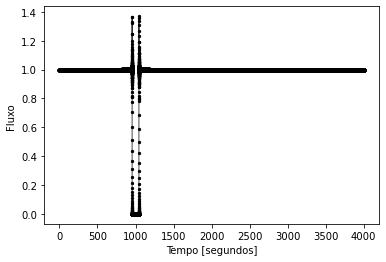

In [599]:
Fres_sat=bar_fresnel(Xs,X01_sat,X02_sat,1,distancia,band)

plt.plot(times,Fres_sat, 'o-',color='black',linewidth= 0.7,markersize=2.3)
plt.ylabel("Fluxo ")
plt.xlabel('Tempo [segundos]')

Text(0.5, 0, 'Tempo [segundos]')

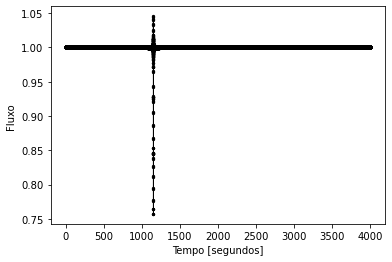

In [600]:
Fres_an1=bar_fresnel(Xs,X01_an,X02_an,prof_otica,distancia,band)
plt.plot(times,Fres_an1, 'o-',color='black',linewidth= 0.7,markersize=2.3)
plt.ylabel("Fluxo ")
plt.xlabel('Tempo [segundos]')

Text(0.5, 0, 'Tempo [segundos]')

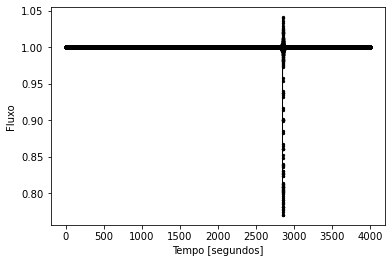

In [601]:
Fres_an2=bar_fresnel(Xs,X03_an,X04_an,prof_otica2,distancia,band)
plt.plot(times,Fres_an2, 'o-',color='black',linewidth= 0.7,markersize=2.3)
plt.ylabel("Fluxo ")
plt.xlabel('Tempo [segundos]')

Text(0.5, 0, 'Tempo [segundos]')

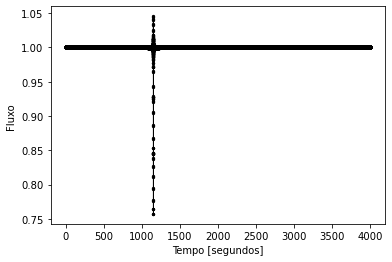

In [602]:
Fres_an3=bar_fresnel(Xs,X05_an,X06_an,prof_otica3,distancia,band)
plt.plot(times,Fres_an1, 'o-',color='black',linewidth= 0.7,markersize=2.3)
plt.ylabel("Fluxo ")
plt.xlabel('Tempo [segundos]')

Text(0.5, 0, 'Tempo [segundos]')

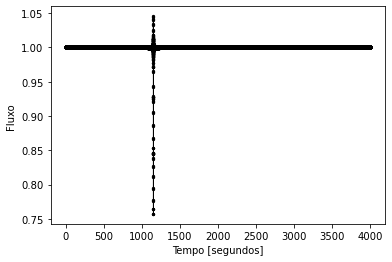

In [603]:
Fres_an4=bar_fresnel(Xs,X07_an,X08_an,prof_otica4,distancia,band)
plt.plot(times,Fres_an1, 'o-',color='black',linewidth= 0.7,markersize=2.3)
plt.ylabel("Fluxo ")
plt.xlabel('Tempo [segundos]')

Text(0.5, 0, 'Tempo [segundos]')

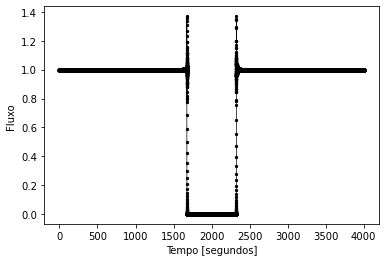

In [604]:
Fres=bar_fresnel(Xs,X01,X02,1,distancia,band)
plt.plot(times,Fres, 'o-',color='black',linewidth= 0.7,markersize=2.3)
plt.ylabel("Fluxo ")
plt.xlabel('Tempo [segundos]')


Text(0.5, 1.0, 'Simulação com Difração de Fresnel')

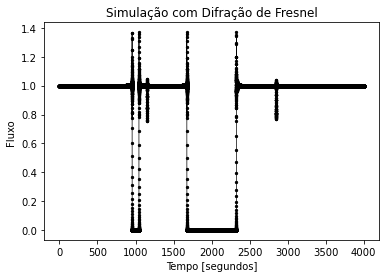

In [605]:
Fres_tot = (Fres*Fres_sat*Fres_an1*Fres_an2*Fres_an3*Fres_an4)
plt.plot(times,Fres_tot, 'o-',color='black',linewidth= 0.7,markersize=2.3)
plt.ylabel("Fluxo ")
plt.xlabel('Tempo [segundos]')
plt.title("Simulação com Difração de Fresnel")

In [606]:
print(fluxo_instant)

9.154357111978134e-17


In [ ]:
tempo_a =  tmini
#if fluxo_instante > 20000:
#        print("Por questão de tempo computacional foi realizada uma aproximação no número de fótons")
while tempo_a < tmaxi:
    fluxo_instante = contagem_fluxo_anel2(tempo_a,mag_obj,mag_star, area_telescopio, 
                                                  tempexp, band, inicio, fim, prof_otica, prof_otica2, prof_otica3, prof_otica4, inicio_anel1, 
                                                  fim_anel1, inicio_anel2, fim_anel2, inicio_anel3, fim_anel3, inicio_anel4, fim_anel4)
    #ceu = random.gauss(1,0.03)*contagem_fluxo_ceu(tempo_a, area_telescopio, tempexp,band, inicio, fim) 
    #print(fluxo_instante)
    ####ARRUMAR NO RUIDO TERMICO QUE É COM NUMERO DE PIXEL NÃO COM O FLUXO
    fluxo_instant = fluxo_instante#+(np.random.normal(0,ruido_termico(temperatura,fluxo_instante,tempexp)))#np.random.normal(fluxo_instante, 0.3)#var_fase**(1/2))#ceu+random.gauss(1, 0.03)*fluxo_instante
   # print(fluxo_instante)
    fluxo_instant = fluxo_instante #+ erro_fase(fluxo_instante,var_fase)
    #fluxo_instant = abs(fluxo_instant)
    flua.append(fluxo_instant)
    tempo_a += cyc
print (flua)



Text(0.5, 1.0, 'Simulação P9')

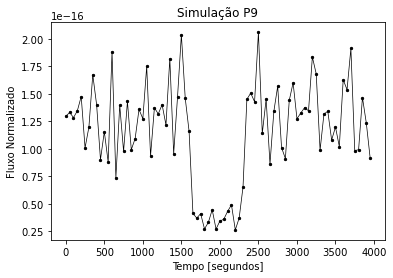

In [588]:
plt.plot(times,flua, 'o-',color='black',linewidth= 0.7,markersize=2.3)
plt.ylabel("Fluxo Normalizado")
plt.xlabel('Tempo [segundos]')
plt.title("Simulação P9")

In [589]:
##########NORMALIZAÇÃO
i=0
med=np.median(flua[0:40])
for i in range(len(flua)):
    flua[i]=flua[i]/med
    i=i+1

In [590]:

Flua_fres=[i for i in range(len(flua))]


In [591]:
i=0
while i < len(flua):
    if flua[i] == 1:
        Flua_fres[i]=flua[i]*Fres_tot[i]
    else:
        Flua_fres[i]=(flua[i]+Fres_tot[i])/2
    i+=1
print(flua)
print(Flua_fres)

[1.039037523116437, 1.0694391578396476, 1.030512833555354, 1.0807509878875414, 1.1850251822903624, 0.8093721612062742, 0.9613738099002819, 1.3448897333741492, 1.1251582597177618, 0.723394907390569, 0.9277898233433256, 0.7054794855742751, 1.513937227693194, 0.5901164994980693, 1.1220063866237546, 0.7842933625242382, 1.1488784722286618, 0.7960362970024919, 0.8773992238367629, 1.0905838056189296, 1.0229891026252829, 1.4061894557271988, 0.7508270664116184, 1.1026725596049363, 1.05773464037883, 1.1257295452087497, 0.9770108973747172, 1.4625410642117, 0.7663897309927433, 1.180307797703984, 1.636819956920774, 1.1730584477113797, 0.9307084275042142, 0.32977458740665694, 0.29572002126387614, 0.3284285664950965, 0.21656994258729587, 0.2640065713357664, 0.35707814538227134, 0.2154364297500724, 0.2746838740037746, 0.2869723466616959, 0.34496563283845716, 0.3927124269703352, 0.20931002121128092, 0.29622869937072593, 0.5230226905759774, 1.1644879087366087, 1.210258990148141, 1.1463454887475364, 1.65

In [592]:
##########NORMALIZAÇÃO
j=0
med=(np.median(Flua_fres))
Flua_fresn=[]
for j in range(len(Flua_fres)):
    Flua_fresn.append(Flua_fres[j]/med)
    j=j+1


Text(0.5, 1.0, 'Simulação com Difração de Fresnel')

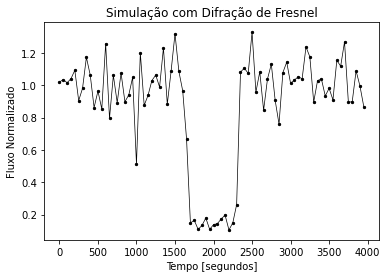

In [ ]:
plt.plot(times,Flua_fres, 'o-',color='black',linewidth= 0.7,markersize=2.3)
plt.ylabel("Fluxo Normalizado")
plt.xlabel('Tempo [segundos]')
plt.title("Simulação com Difração de Fresnel")#"{:.1f}s_{:.1f}ms_{:.0f}Mm_{:.0f}UA_{:.0f}_{:.0f}_{:.0f}_{:.1f}m_{:.0f}".format(
        #tempexp,vel,diametro_corpo/1000, distancia, diametro_estrela, mag_star,band, diam_teles/1000,mag_obj))
#plt.savefig("teste")
    #"mSt{:.0f}_{:.1f}s_{:.0f}Mm_Rg_{:.2f}_{:.0f}km_sa_Mir_T_{:.1f}m".format(
    #mag_star,tempexp,diametro_corpo/1000, prof_otica, espessura_anel, diam_teles/1000))
#
# plt.savefig("imags/_{:.1f}s_{:.1f}ms_{:.0f}Mm_{:.0f}UA_{:.0f}_{:.0f}_{:.0f}_{:.1f}m_{:.0f}_sat{:.0f}_{:.0f}_anel_{:.0f}_{:.0f}_{:.4f}.png".format
#    (tempexp, vel, diametro_corpo/1000, distancia, diametro_estrela, mag_star, band, (diam_teles/1000), mag_obj, diametro_sat, distancia_sat, diametro_anel, espessura_anel,prof_otica),dpi = 300)    
                                                     
                                
    #"magStar{:.1f}_{:.1f}s_{:.0f}Mm_Ring_{:.2f}_{:.0f}km_sat_Miranda_Tel_{:.1f}m.png".format(
    #mag_star,tempexp,diametro_corpo/1000, prof_otica, espessura_anel, diam_teles/1000)
    #        ,dpi = 300)                


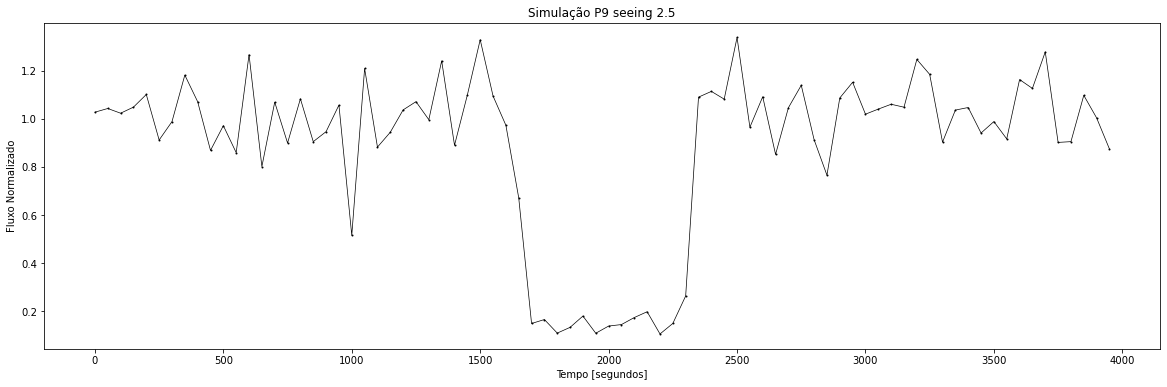

In [ ]:
plt.figure(figsize=(20,6))
plt.plot(times,Flua_fresn, 'o-',color='black',linewidth= 0.7,markersize=1)
plt.ylabel("Fluxo Normalizado")
plt.xlabel('Tempo [segundos]')
plt.title("Simulação P9 seeing 2.5")#"{:.1f}s_{:.1f}ms_{:.0f}Mm_{:.0f}UA_{:.0f}_{:.0f}_{:.0f}_{:.1f}m_{:.0f}".format(
        #tempexp,vel,diametro_corpo/1000, distancia, diametro_estrela, mag_star,band, diam_teles/1000,mag_obj))
#plt.savefig("teste")
    #"mSt{:.0f}_{:.1f}s_{:.0f}Mm_Rg_{:.2f}_{:.0f}km_sa_Mir_T_{:.1f}m".format(
    #mag_star,tempexp,diametro_corpo/1000, prof_otica, espessura_anel, diam_teles/1000))
#
plt.savefig("imags/2.5_0.01.png" ) 
                                                     
    #"magStar{:.1f}_{:.1f}s_{:.0f}Mm_Ring_{:.2f}_{:.0f}km_sat_Miranda_Tel_{:.1f}m.png".format(
    #mag_star,tempexp,diametro_corpo/1000, prof_otica, espessura_anel, diam_teles/1000)
    #        ,dpi = 300)                


Text(0.5, 1.0, 'Simulação com ruído da variação da fase')

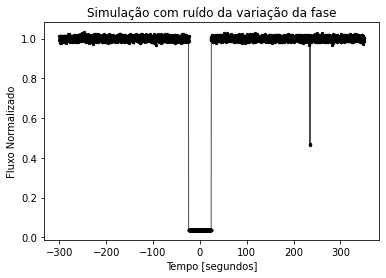

In [755]:
plt.plot(times,flua, 'o-',color='black',linewidth= 0.7,markersize=2.3)
plt.ylabel("Fluxo Normalizado")
plt.xlabel('Tempo [segundos]')
plt.title("Simulação com ruído da variação da fase")

In [524]:
rui_term = np.random.normal(0,ruido_termico(200,4,tempexp))
print(rui_term)

0.010233813031059287


In [424]:
tempo_a =  tmini
while tempo_a < tmaxi:
    fluxo_instante = contagem_fluxo(tempo_a, mag_obj, mag_star, area_telescopio, 
                                    tempexp, band, inicio, fim 
                                                 )
    #ruido
    #ceu = random.gauss(1,0.03)*contagem_fluxo_ceu(tempo_a, area_telescopio, tempexp,band, inicio, fim)
    T=273
    rui_term = np.random.normal(0,ruido_termico(T,4,tempexp))

    fluxo_instant = fluxo_instante + rui_term   
    flua.append(fluxo_instant)
    tempo_a += cyc
    print(rui_term)
print (flua)

TypeError: Flux_lambda_ruido() takes 1 positional argument but 2 were given

In [63]:
lc = LightCurve(name = 'Planet 9 simulation + ',
tref = '2022-08-22 00:00:02',
flux = np.array(flua),
time = times,
central_bandpass = band,
exptime = cyc,
vel = vel, 
dist = distancia,
d_star = diametro_estrela
    )
lc.plot_lc()

ValueError: time and flux must have the same length

In [64]:
lc.normalize()
lc.plot_lc()

NameError: name 'lc' is not defined

c:\Users\Wellington\anaconda3\lib\site-packages\numpy\core\_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Wellington\anaconda3\lib\site-packages\numpy\core\_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


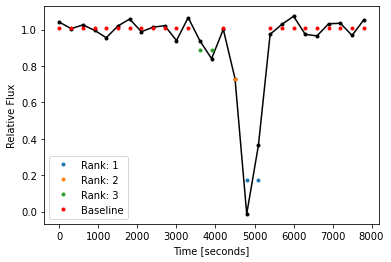

In [ ]:
pre=lc.occ_detect(
    n_detections=3,
                  plot=True)

In [ ]:
pre['occ_mask']
diam_star = diametro_estrela


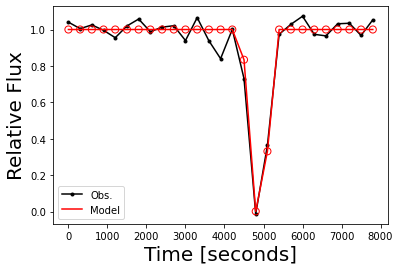

In [ ]:
lc1=lc.occ_model(immersion_time=pre['immersion_time'][0]-50, 
             emersion_time=pre['emersion_time'][0]+50, 
             opacity=1, mask= [False, False, False, False, False, False, False, False, False,
        False, False, False, True, True, False, True,  True,  True,
        False, False, False, False, False, False, False, False, False])
lc1=lc.plot_lc()
lc1

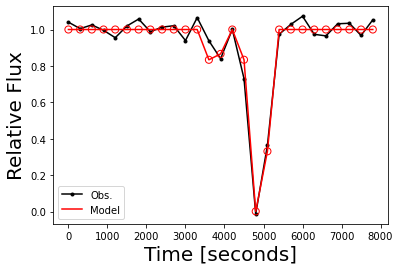

In [ ]:
lc.occ_model(immersion_time=pre['immersion_time'][2]+50,
             emersion_time=pre['emersion_time'][2]+50,
             opacity=1, mask= pre['occ_mask'][2],flux_min=0.8)
lc.plot_lc()

In [ ]:
temp = tmini

In [ ]:
with open('simulation.txt', 'w') as output:
    for flux in flua:
        round(temp,3)
        output.write(str(temp) +' , ')
        output.write(str(flux) + '\n')
        temp = temp + cyc
        

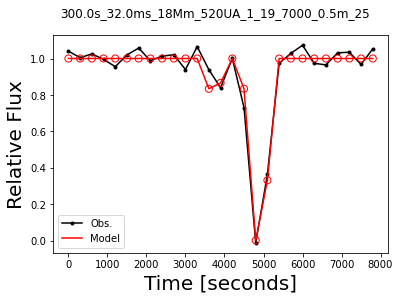

In [ ]:
lc.plot_lc()
plt.ylabel("Relative Flux")
plt.xlabel('Time [seconds]')
plt.suptitle("{:.1f}s_{:.1f}ms_{:.0f}Mm_{:.0f}UA_{:.0f}_{:.0f}_{:.0f}_{:.1f}m_{:.0f}".format(
            tempexp,vel,diametro_corpo/1000, distancia, diam_star, mag_star,band, diam_teles/1000,mag_obj))
plt.savefig("21_04_08h/_{:.1f}s_{:.1f}ms_{:.0f}Mm_{:.0f}UA_{:.0f}_{:.0f}_{:.0f}_{:.1f}m_{:.0f}_sat{:.0f}_{:.0f}_anel_{:.0f}_{:.0f}_{:.4f}.png".format
        (tempexp, vel, diametro_corpo/1000, distancia, diam_star, mag_star, band, (diam_teles/1000), mag_obj, diametro_sat, distancia_sat, diametro_anel,
        espessura_anel,prof_otica),dpi = 300)    

In [ ]:
df.at[a,'Diametro']=pd.Series(diametro_corpo)
df.at[a, 'Distancia']  = pd.Series(distancia)
df.at[a, 'Velocidade']  = pd.Series(vel)
df.at[a, 'Magnitude']  = pd.Series(mag_obj)
df.at[a, 'Duração']  = pd.Series(fim-inicio)
df.at[a, 'Tempo predito']  = pd.Series(cyc)
df.at[a, 'Tempo exposição']  = pd.Series(float(tempexp))#lc.lambda_0)) 
df.at[a, 'Tempo ciclo']  = pd.Series(float(cyc))
df.at[a, 'Largura de banda']  = pd.Series(band)
df.at[a, 'Diametro estrela'] = pd.Series(diametro_estrela) 
df.at[a, 'Magnitude estrela'] = pd.Series(float(mag_star))
df.at[a, 'Escala de Fresnel'] = pd.Series(float(lc.fresnel_scale))
df.at[a, 'Telescopio'] = pd.Series(float(diam_teles))
a=a+1


In [ ]:
df

,Diametro,Distancia,Velocidade,Magnitude,Duração,Tempo predito,Tempo exposição,Tempo ciclo,Largura de banda,Diametro estrela,Magnitude estrela,Escala de Fresnel,Telescopio


In [ ]:
#Fresnel_Scale = []
tempos_imersao = []
tempos_emersao = []
data = { 
        'P9 Diameter': [],
        'P9 Distance': [],#distancias,
        'Velocity': [],#velocidades,
        'Magnitude': [],#magnitudes,
        'Occultation duration': [],#duracoes,
        'Botton flux': [],#tempos_predicao,
        'Exposure time': [],#tempos_exposicao,
        'Cycle time': [],#tempos_ciclo,
        'Bandpass': [],#bandas,
        'Star size': [],
        'Star Magnitude': [],
        'Fresnel Scale': [],
        'Telescope size': []
}
df = pd.DataFrame(data)
new_row = pd.Series()
a=0

C:\Users\Wellington\AppData\Local\Temp\ipykernel_18960\834110658.py:20: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  new_row = pd.Series()


In [ ]:
j=0
a=0
a1=[1]
tab_fluxos = []
#ok
tempos_exp = [ 0.1]  #300, 100, 10, 1

#ok
diam_satel = [2700, 500]#Triton 2700 Miranda 500
#distancias_sat = [60000, 250000]#Triton 60000 Miranda 250000

#ok
profundidades = [0.003, 0.1, 0.5, 1]
diametros_anel = [53200, 51000, 42000, 37800]
espessuras = [100, 20, 2, 2000]

#magnitudes = [19, 20, 25]
#diametros = [18432, 19548, 20665]
#ok
distancias = [240, 300, 520]
#ok
velocidades =[30,31,32]

#ok
diametros_estrelas = [0.98, 7.84]
#ok
magnitudes_estrelas = [12,19,21]

#ok
bandas =[ 5500, 6500, 7000]

#ok
telescopios = [500, 1000]



flua = []
tmini = 0.1
tmaxi = 8000
for i in tempos_exp: #varia cada tempo de ciclo
    tempexp = i 
    for j in velocidades : # varia cada velocidade
        vel = j 
        for l in distancias:
            distancia = l
            if distancia == 240:
                diametro_corpo = 20665
                mag_obj = -4.79 + 5*np.log10(distancia*(distancia-1))
            elif distancia == 300:
                diametro_corpo = 19548
                mag_obj = -3.76 + 5*np.log10(distancia*(distancia-1))
            elif distancia == 520:
                diametro_corpo = 18432
                mag_obj = -2.16 + 5*np.log10(distancia*(distancia-1))
            for k in diam_satel: #varia o diametro do satelite
                diametro_sat = k
                if diametro_sat == 2700:
                    magi_sat = -1.25 #aplica a magnitude absoluta pro satélite
                    mag_sat=calculo_magnitude(magi_sat, distancia)
                    distancia_sat= 60000
                    centro_ocultacao = 5000
                elif diametro_sat == 500:
                    magi_sat = 3.49
                    mag_sat=calculo_magnitude(magi_sat, distancia)
                    distancia_sat = 250000 
                    centro_ocultacao = 5000
                
                   
                        #EQUAÇÃO PARA MAGNITUDE CONFORME TAMANHO E DISTANCIA
                 #       magn_sat = mag_sat + 5*np.log10(dist_esti*(dist_esti-1)) #https://astronomy.stackexchange.com/questions/48314/calculating-the-luminosity-of-a-comet
                  #      if m == 20665:
                   #         mag_obj = -4.79 + 5*np.log10(dist_esti*(dist_esti-1))
                    #    elif m == 19548:
                     #       mag_obj = -3.76 + 5*np.log10(dist_esti*(dist_esti-1))
                      #  elif m == 18432:
                       #     mag_obj = -2.16 + 5*np.log10(dist_esti*(dist_esti-1))
                for n in diametros_estrelas: #varia o diâmetro da estrela
                                #VER A INFLUENCIA DO DIAMETRO NA OCULTAÇÃO -> na queda de magnitude?
                            diam_star=n 
                            for o in magnitudes_estrelas:
                                mag_star = o
                            #    for p in a1: #centro_ocultacao = 5000 #Triton 2800 miranda 5000     varia o tempo de predicao?
                                    
                                          #gera uma curva de luz falsa pra calcular a queda de magnitude
                                for q in bandas:
                                        band = q
                                        for r in telescopios:
                                            diam_teles = r
                                            for s in profundidades:
                                                prof_otica = s
                                                for t in a1:
                                                    for u in espessuras:
                                                        espessura_anel = u
                                                        for v in diametros_anel:
                                                             diametro_anel = v

                                                        inicio = centro_ocultacao - diametro_corpo/vel/2
                                                        fim = centro_ocultacao + diametro_corpo/vel/2
                                                        cyc = tempexp + 0.01
                                                        times = np.arange(tmini, tmaxi, cyc)
                                                        area_telescopio = np.pi*(diam_teles)**2 #cm²
                                                        #https://arxiv.org/ftp/arxiv/papers/1805/1805.08963.pdf#:~:text=Uranus%20rings%20are%20dense%2C%20made,range%20between%200.1%20and%201.
                                                        #https://arxiv.org/pdf/1906.11728.pdf
                                                        
                                                        inicio_anel1 = centro_ocultacao - diametro_anel/vel/2 - espessura_anel/vel/2
                                                        fim_anel1 = centro_ocultacao - diametro_anel/vel/2 + espessura_anel/vel/2
                                                        inicio_anel2 = centro_ocultacao + diametro_anel/vel/2 - espessura_anel/vel/2
                                                        fim_anel2 = centro_ocultacao + diametro_anel/vel/2 + espessura_anel/vel/2

                                                        inicio_sat = centro_ocultacao - distancia_sat/vel/2 - diametro_sat/vel/2
                                                        fim_sat = centro_ocultacao - distancia_sat/vel/2 + diametro_sat/vel/2
                                                        tempo_a =  tmini
                                                        while tempo_a < tmaxi:
                                                            fluxo_instante = contagem_fluxo_anel_satelite(tempo_a, mag_obj, mag_star
                                                                                                            , mag_sat
                                                                                                            , area_telescopio, tempexp, band, inicio, fim 
                                                                                                            , prof_otica,inicio_anel1, fim_anel1, inicio_anel2, fim_anel2
                                                                                                            , inicio_sat, fim_sat)
                                                                #ruido
                                                            ceu = random.gauss(1,0.03)*contagem_fluxo_ceu(tempo_a, area_telescopio, tempexp, band, inicio, fim)
                                                                
                                                            fluxo_instant = ceu+random.gauss(1, 0.03)*fluxo_instante
                                                            flua.append(fluxo_instant)
                                                            tempo_a += cyc
                                                        
                                                        lc = LightCurve(name = 'Planet 9 simulation + ',
                                                        tref = '2022-08-22 00:00:02',
                                                        flux = np.array(flua),
                                                        time = times,
                                                        central_bandpass = band,
                                                        exptime = tempexp,
                                                        vel = vel, 
                                                        dist = distancia,
                                                        d_star = diam_star
                                                        )
                                                        lc.plot_lc()
                                                        plt.plot(times,flua, 'o-',color='black',linewidth= 0.7,markersize=2.3)
                                                        plt.ylabel("Photon Flux")
                                                        plt.xlabel('Time [seconds]')
                                                        plt.title("{:.1f}s_{:.1f}ms_{:.0f}Mm_{:.0f}UA_{:.0f}_{:.0f}_{:.0f}_{:.1f}m_{:.0f}".format(
                                                            tempexp,vel,diametro_corpo/1000, distancia, diam_star, mag_star,band, diam_teles/1000,mag_obj))
                                                        plt.savefig("21_04_08h/_{:.1f}s_{:.1f}ms_{:.0f}Mm_{:.0f}UA_{:.0f}_{:.0f}_{:.0f}_{:.1f}m_{:.0f}_sat{:.0f}_{:.0f}_anel_{:.0f}_{:.0f}_{:.4f}.png".format
                                                            (tempexp, vel, diametro_corpo/1000, distancia, diam_star, mag_star, band, (diam_teles/1000), mag_obj, diametro_sat, distancia_sat, diametro_anel,
                                                              espessura_anel,prof_otica),dpi = 300)    
                                                        plt.clf()
                                                        df.loc[a]=new_row

                                                        df.at[a,'P9 Diameter']=pd.Series(diametro_corpo)
                                                        df.at[a, 'P9 Distance']  = pd.Series(distancia)
                                                        df.at[a, 'Velocity']  = pd.Series(vel)
                                                        df.at[a, 'Magnitude']  = pd.Series(mag_obj)
                                                        df.at[a, 'Occultation duration']  = pd.Series(fim-inicio)
                                                        df.at[a, 'Botton flux']  = pd.Series(float(min(flua)))
                                                        df.at[a, 'Exposure time']  = pd.Series(float(tempexp))#lc.lambda_0)) 
                                                        df.at[a, 'Cycle time']  = pd.Series(float(cyc))
                                                        df.at[a, 'Bandpass']  = pd.Series(band)
                                                        df.at[a, 'Star size'] = pd.Series(diam_star) 
                                                        df.at[a, 'Star Magnitude'] = pd.Series(float(mag_star))
                                                        df.at[a, 'Fresnel Scale'] = pd.Series(float(lc.fresnel_scale))
                                                        df.at[a, 'Telescope size'] = pd.Series(float(diam_teles))
                                                        a=a+1
                                                        flua =[]
                                                    

<Figure size 432x288 with 0 Axes>

C:\Users\Wellington\AppData\Local\Temp\ipykernel_18960\3300026229.py:6: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("21_04_08h/heat_map", dpi=500,figsize = (30,6))


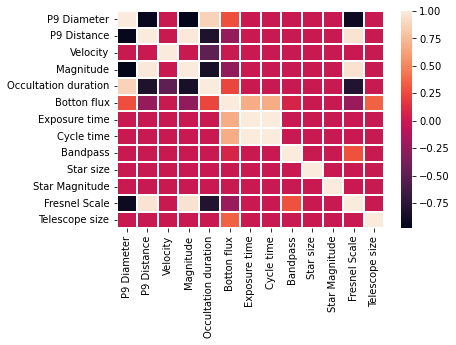

In [ ]:
import seaborn as sn
data = df
correlation = data.corr()
plot = sn.heatmap(correlation, annot = False, fmt=".1f",  linewidths=.1)
plot#testar a função de calculo de magnitude pro corpo
plt.savefig("21_04_08h/heat_map", dpi=500,figsize = (30,6))

In [ ]:
df

,P9 Diameter,P9 Distance,Velocity,Magnitude,Occultation duration,Botton flux,Exposure time,Cycle time,Bandpass,Star size,Star Magnitude,Fresnel Scale,Telescope size
0,20665.0,240.0,30.0,19.003046,688.833333,1.434267e+08,300.0,300.01,5500.0,0.98,12.0,314.220615,500.0
1,20665.0,240.0,30.0,19.003046,688.833333,1.470775e+08,300.0,300.01,5500.0,0.98,12.0,314.220615,500.0
2,20665.0,240.0,30.0,19.003046,688.833333,1.527740e+08,300.0,300.01,5500.0,0.98,12.0,314.220615,500.0
3,20665.0,240.0,30.0,19.003046,688.833333,1.468868e+08,300.0,300.01,5500.0,0.98,12.0,314.220615,500.0
4,20665.0,240.0,30.0,19.003046,688.833333,1.457374e+08,300.0,300.01,5500.0,0.98,12.0,314.220615,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41467,18432.0,520.0,32.0,24.995854,576.000000,6.882638e+05,1.0,1.01,7000.0,7.84,21.0,521.793182,1000.0
41468,18432.0,520.0,32.0,24.995854,576.000000,6.842159e+05,1.0,1.01,7000.0,7.84,21.0,521.793182,1000.0
41469,18432.0,520.0,32.0,24.995854,576.000000,6.926814e+05,1.0,1.01,7000.0,7.84,21.0,521.793182,1000.0
41470,18432.0,520.0,32.0,24.995854,576.000000,6.691547e+05,1.0,1.01,7000.0,7.84,21.0,521.793182,1000.0


# Inserindo os dados do Objeto ocultador

In [ ]:
#AJUSTAR PARA ELIMINAR VALORES IGUAIS DAS TABELAS

corpos = input('Quantos corpos deseja simular? (digite um número inteiro)')
#def mod():
#gerando listas para cada variavel
#diametros = []
#distancias = []
#velocidades = []
#magnitudes = []
#diametros_angulares = []
#duracoes = []
#objetos = []
j=0
while j < int(corpos): #para cada simulação entrada das informações
    j = j + 1
    diam_esti = float(input("Digite o diâmetro esperado para o " + str(j) + " corpo, em km: "))
    dist_esti = float(input("Digite a distância esperada para o " + str(j) + " corpo, em UA: "))
    vel = float(input('Digite a velocidade que ocorrerá a ' + str(j) + ' ocultação: '))
    magn = float(input('Digite a magnitude esperada pelo ' + str(j) + ' corpo: '))
    d_ang = diametro_angular(diam_esti, dist_esti)
#    d_ang = (np.arctan(diam_esti/(dist_esti*ua)))*(360/(2*np.pi))*3600*1000
    duracao = diam_esti/vel
    nome = input('Digite o nome do ' + str(j) + 'º corpo que será realizada a ocultação: ')
    #modificar = input("Você deseja modificar os valores do corpo? 1-Sim 2-Não")
    obj = Body(name = nome, database=None,  spkid = 1, diameter = diam_esti)
    #adicionando cada variavel em uma tabela
    #diametros.append(diam_esti)
    #distancias.append(dist_esti)
    #velocidades.append(vel)
    #magnitudes.append(magn)
    #diametros_angulares.append(d_ang)
    #duracoes.append(duracao)
    #objetos.append(obj)


sat = input("Deseja simular um satélite em conjunto? 1 - Sim, 2 - Não")
#anel = input("Deseja simular um anel em conjunto? 1- Sim, 2-Não")

# verificar no horizon a existencia do corpo
    #try :
    #    eph_hor = EphemHorizons(name=nome)
    #    obj = Body(name = nome, ephem = eph_hor)
    #    if modificar == '1':
    #        diam_esti = obj.diameter
    #        magn = obj.apparent_magnitude
    #    pass    
        # caso queira modificar os valores tabelados
    #except ValueError ("Object was not located on satdb or sbdb"):
    #mod()
        #obj = Body(name = nome)


    #adicionar se quer anel ou satélite... tamanhos, densidades, etc.

# Inicializando os dados do anel

In [ ]:
#diam_anel = 
#excentricidade_anel =
#densidade_anel = 
#largura_anel = 
#albedo_anel = 
#optical_depth =

# p’ = 1 – I/I_0 
# opacidade aparente: fração de queda de flux da estrela (p’=0 transparente, p’=1 opaco);
# onde I_0 fluxo total e I fluxo no evento.

# tau'= -ln (1- p') 
# profundidade óptica aparente

# Inicializando os dados do satélite

In [ ]:
if sat == "1":
    satelites = input('Quantos satelites deseja simular? ')
    j=0
    #diam_satel =[]
   # mag_satel = []
    #magabs_satel = []
    #dist_satel = []
    while j < int(satelites):
        j = j + 1
        diam_sat = float(input("Digite o diametro esperado para o " + str(j) + " satelite: ") )
        mag_sat = float( input("Digite a magnitude absoluta do " + str(j) + " satélite: ") )
        dist_sat = float( input("Digite a distancia estimada entre o " + str(j) + " satélite e o corpo principal(distancia entre centros): ") )
       # diam_satel.append(diam_sat)
       # magabs_satel.append(mag_sat)
      #  dist_satel.append(dist_sat)

else:
    satelites = 0
    diam_sat = 0
    dist_sat = 0
    mag_sat = 0

# Inserido os dados da ocultação

In [ ]:
time_times = input('Quantos tempos diferentes deseja utilizar? ')
j = 0
#tempos_predicao = []
#tempos_exposicao = []
#tempos_ciclo = []
#bandas = []
while j < int(time_times):
    j = j + 1
    timepred = float(input('Digite o tempo previsto para o centro da ocultação do corpo principal, em segundos: '))
    d_tel = float(input('Digite o diâmetro do telescopio, em metros: '))
    area_tel = (np.pi*d_tel**2)/4
    #d_foc_tel = float(input('Digite a distância focal do telescopio, em metros: '))
    #iradi = float(input('Insira a abertura fotométrica [raio/pixel]: '))
    #camera = input('Digite qual a câmera que está sendo utilizada: ')
    #mag do fundo de ceu/arcsec -> transforma pra contagem (se for necessário)
    #ccdpix = float(input("Insira o tamanho de pixel do CCd [um]: "))
    #fwhm = float(input("Insira a largura meia altura (FWHM) [arcsec]: "))
    #photconst = float(input('Insira o número de fótons que será captado: '))
    tempexp = float(input("Digite o tempo de exposição, em segundos: "))
    tempcyc = float(input('Digite o tempo de ciclo que será usado, em segundos: '))
    band = float(input('Digite a banda que será realizada a observação, em micrometros: '))
   # tempos_predicao.append(timepred)
   # tempos_exposicao.append(tempexp)
   # tempos_ciclo.append(tempcyc)
   # bandas.append(band)
#eq

#pixasec = ccdpix/1000/(1000*d_foc_tel)*360/(2*np.pi)*3600
#pixarea = pixasec*pixasec

#fwhm = fwhm / pixasec

# Inicializando a tabela de dados

In [ ]:
#Fazer uma tabela para cada ocultação com dados para poder utilizar em outro local pra redução e análise dos dados


In [ ]:
#estrelas = []
#diametros_estrelas = []
#magnitudes_estrelas = []
#quedas_magnitude_corpo = []
#quedas_magnitude_satelite = []
#Fresnel_Scale = []
#tempos_imersao = []
#tempos_emersao = []
#data = { 'Diametro': [],#diametros,
#        'Distancia': [],#distancias,
#        'Velocidade': [],#velocidades,
#        'Magnitude': [],#magnitudes,
#        'Diametro angulare': [],#diametros_angulares,
#        'Duração': [],#duracoes,
#        'Objeto': [],#objetos,
#        'Diametro satélite': [],#diam_satel,
#        'Magnitude satélite': [],#mag_satel,
#        'Distancia satélite': [],#dist_satel,
#        'Tempo predito': [],#tempos_predicao,
#        'Tempo exposição': [],#tempos_exposicao,
#        'Tempo ciclo': [],#tempos_ciclo,
#        'Largura de banda': [],#bandas,
#        'Estrela': estrelas, 
#        'Diametro estrela': diametros_estrelas,
#        'Magnitude estrela': magnitudes_estrelas,
#        'Queda de magnitude corpo': quedas_magnitude_corpo,
#        'Queda de magnitude satelite':quedas_magnitude_satelite,
#        'Escala de Fresnel': Fresnel_Scale,
#        'Tempo de imersão': tempos_imersao,
#        'Tempo de Emersão': tempos_emersao
#}
#df = pd.DataFrame(data)
#new_row = pd.Series()
flu = [] #gera uma lista para o fluxo

tmini = float(input('Digite o instante que começa a observação, em segundos: '))
tmaxi = float(input('Digite o instante que se encerra a observação, em segundos: '))
linhas = tmaxi-tmini

# Adicionando a estrela da ocultação

In [ ]:

j = input("Digite o númmero de estrelas que deseja simular a ocultação: ")
k = 0
while k < int(j):
    k = k + 1
    ra = str(input('Digite RA da ' + str(k) +' estrela a ser ocultada: '))
    dec = str(input('Digite DEC da ' + str(k) +' estrela a ser ocultada: '))
    cord = ra +" " + dec
    estr = Star(coord = cord)
    diam_star_k = estr.apparent_diameter(distance = dist_esti, mode='kervella').value
    print('O diâmetro da estrela é de: ' + str(diam_star_k) + "km, de acordo com Kervella")
    diam_star_v = estr.apparent_diameter(distance = dist_esti, mode='van_belle').value
    print('O diâmetro da estrela é de: ' + str(diam_star_v) + "km, de acordo com Van Belle")
    time.sleep(0.5)
    while True:
        e = input('Qual modo voce deseja utilizar? Digite 1 para Kervella e 2 para Van Belle')
        if e =='1':
            diam_star = diam_star_k
            break
        elif e == '2':
            diam_star = diam_star_v
            break
        else:
            ('Numero incorreto, digite novamente.')
#    estrelas.append(estr) 
#    diametros_estrelas.append(diam_star)
    
#print(cord)

ValueError: invalid literal for int() with base 10: ''

## Inicializando a curva de luz com os dados já fornecidos

In [ ]:
#a0 = [0,0,0]
#tim = [0,0,0]
#lc= LightCurve(name=str(nome),
 #               tref = '2022-01-01 00:00:00',
  #              flux = np.array(a0),
   #             time = np.array(tim), 
    #            exptime = float(tempexp),
     #           vel = float(vel), 
      #          dist = float(dist_esti), 
       #         d_star = float(diam_star),
        #        central_bandpass = band
         #       )
                
#lc.calc_magnitude_drop(mag_star=float(estr.mag['G']), mag_obj = magn)

#inicio = timepred - duracao/2
#fim = timepred + duracao/2
#x = lc.bottom_flux
#lc.calc_magnitude_drop(mag_star=float(estr.mag['G']), mag_obj = mag_sat)
#y = lc.bottom_flux
#inicio_sat = timepred - dist_sat/vel - (diam_sat/2)/vel
#fim_sat = timepred - dist_sat/vel + (diam_sat/2)/vel

# Função que gera o ruido do sistema

In [ ]:
#verifica quantas ocultações serão simuladas
if int(corpos) == 0:
    corpos = 1
if int(satelites) == 0:
    satelites =1
if int(time_times) == 0:    
    time_times = 1
fluxos = int(corpos)*int(satelites)*int(time_times)
#len(time_times)
fluxos


1

In [ ]:
#Equação do S/R dissertação ribas pagina 40 equação 3.4
#S/R = Co **(1/2) / sqrt(1/g + n/Co * sigfundo**2  * (1+1/p))
#Co é a contagem do objeto
#g é o ganho
#n é o numero de pixels sobre a abertura
# p é o fundo (outrora de céu) estimado por um anel em torno do alvo que nos dá o grau de variancia estimado para cada pixel sobre o objeto 1/p
#sigfundo é a soma de B**2 com a média das contagens do fundo por pixel "fmed" e ainda uma contribuição espúria de objetos fracos de fundo na linha de visada e**2

In [ ]:
#def fluxo(tmin, tmax, cyc):
#    flu.clear() #limpa a lista
#    inicio_sat = timepred - dist_sat/vel - (diam_sat/2)/vel
#    fim_sat = timepred - dist_sat/vel + (diam_sat/2)/vel
#    inicio = timepred - duracao/2
#    fim = timepred + duracao/2
#    for t in np.arange(tmin, tmax, cyc): #gerando dados com ruido
#        if t < inicio_sat or t > fim:
#            flux = random.gauss(1, 0.03) #flux_star #media, desvio padrão
#        elif t > inicio_sat and t < fim_sat:
#            flux =  random.gauss(y, 0.03) 
#        elif t == inicio_sat or t == fim_sat:
#            flux = random.gauss(0.5, 0.03)
#        elif t > fim_sat and t < inicio:
#            flux = random.gauss(1, 0.03)
#        elif t > inicio and t < fim:
#            flux =  random.gauss(x, 0.03) 
#        elif t == inicio or t == fim:
#            flux = random.gauss(0.5,0.03)
#        flu.append(flux) #adiciona o fluxo gerado na lista
#    return(flu)
#a = fluxo(tmini, tmaxi, tempcyc)

# Iniciando a simulação da ocultação

In [ ]:
#  C:\Users\Wellington\anaconda3\Lib\site-packages\sora\star

In [ ]:
t = 0
cyc = tempcyc#tempos_ciclo[0]
vel = vel#velocidades[0]
diam_sat = diam_sat#diam_satel[0]
mag_sat = mag_sat #absoluta
dist_sat = dist_sat#dist_satel[0]
diam_esti = diam_esti#diametros[0]
duracao = diam_esti/vel
dist_esti = dist_esti #distancias[0]
magn_sat = calculo_magnitude(dist_esti,mag_sat)
#magn_sat = mag_sat + 5*np.log10(dist_esti*(dist_esti-1))
mag_obj = calculo_magnitude(dist_esti,magn)
#mag_obj = -4.79 + 5*np.log10(dist_esti*(dist_esti-1))
diam_star = diam_star #diametros_estrelas[0]
timepred = 15000
times = np.arange(tmini, tmaxi, cyc) #lista com os instantes de inicio e fim da observação
a0 = [0,0,0]
tim = [0,0,0]
lc= LightCurve(name=str(nome),
    tref = '2022-01-01 00:00:00',
    flux = np.array(a0),
    time = np.array(tim), 
    exptime = float(cyc),
    vel = float(vel), 
    dist = float(dist_esti), 
    d_star = float(diam_star),
    central_bandpass = band
    )
magni_obj = -2.5*np.log10(10**(-0.4*mag_obj)+10**(-0.4*magn_sat))                    
lc.calc_magnitude_drop(mag_star=float(estr.mag['G']), mag_obj = magni_obj)

inicio = timepred - duracao/2
fim = timepred + duracao/2
x = lc.bottom_flux
magni_sat = -2.5*np.log10(10**(-0.4*mag_obj) + 10**(-0.4*magn_sat))
lc.calc_magnitude_drop(mag_star=float(estr.mag['G']), mag_obj = magni_sat)
y = lc.bottom_flux #https://www.astro.keele.ac.uk/jkt/pubs/JKTeq-fluxsum.pdf
                                


inicio_sat = timepred - dist_sat/vel - (diam_sat/2)/vel
fim_sat = timepred - dist_sat/vel + (diam_sat/2)/vel
#gera o fluxo para as variaveis utilizadas
def fluxo(tmin, tmax, cyc):
    flu.clear() #limpa a lista
    #inicio_sat = timepred - dist_sat/vel - (diam_sat/2)/vel
    #fim_sat = timepred - dist_sat/vel + (diam_sat/2)/vel
    #inicio = timepred - duracao/2
    #fim = timepred + duracao/2
    for t in np.arange(tmin, tmax, cyc): #gerando dados com ruido
        if t < inicio_sat or t > fim:
            flux = random.gauss(1, 0.03) #flux_star #media, desvio padrão
        elif t > inicio_sat and t < fim_sat:
            flux =  random.gauss(y, 0.03) #ajustar o valor minimmo do fluxo para a soma da magnitude dos corpos
        elif t == inicio_sat or t == fim_sat:
            flux = random.gauss(0.5, 0.03)
        elif t > fim_sat and t < inicio:
            flux = random.gauss(1, 0.03)
        elif t > inicio and t < fim:
            flux =  random.gauss(x, 0.03) 
        elif t == inicio or t == fim:
            flux = random.gauss(0.5,0.03)
        flu.append(flux) #adiciona o fluxo gerado na lista
    return(flu)
if True:
    #gera a curva de luz do corpo

        
    a = fluxo(tmini, tmaxi, cyc)
    # tab_fluxos.append(a)    
    lc = LightCurve(name = 'Planet 9 simulation + ' + str(t),
    tref = '2022-08-22 00:00:02',
    flux = np.array(flua),
    time = times,
    central_bandpass = band,
    exptime = cyc,
    vel = vel, 
    dist = dist_esti,
    d_star = diam_star
    )
lc.plot_lc()
pl.title("P9{:.0f};{:.0f}UA;{:.1f};DS{:.2f}km;exp{:.1f}s;M_Sat{:.2f};{:.2f}km".format(diam_esti, 
dist_esti,
mag_obj,
diam_star,  
cyc,
magn_sat,
diam_sat)) 
#salva a curva de luz
pl.savefig('Figs/{}_P9_{:.0f}_{}UA_{:.1f}_DS{:.2f}km_exp{:.1f}s_M_Sat{:.2f}_{:.2f}km.png'.format(t,
diam_esti, 
dist_esti,
mag_obj,
diam_star,  
cyc,
magn_sat,
diam_sat, dpi=800))
pl.clf()
#df.loc[t]=new_row
#df.at[t,'Diametro']=pd.Series(diam_esti)
#df.at[t, 'Distancia']  = pd.Series(dist_esti)
#df.at[t, 'Diametro angulare']  = pd.Series(d_ang)
#df.at[t, 'Velocidade']  = pd.Series(vel)
#df.at[t,'Magnitude estrela']=pd.Series(estr.mag.get('G'))
#df.at[t, 'Magnitude']  = pd.Series(magn)
#df.at[t, 'Diametro estrela']  = pd.Series(p)
#df.at[t, 'Queda de magnitude corpo']  = pd.Series(x)
#df.at[t, 'Tempo ciclo']  = pd.Series(cyc)
#df.at[t, 'Largura de banda']  = pd.Series(float(lc.lambda_0)) 
#df.at[t, 'Escala de Fresnel']  = pd.Series(float(lc.fresnel_scale))
#df.at[t, 'Duração']  = pd.Series(duracao)
#df.at[t, 'Queda de magnitude satelite']
t=t+1

NameError: name 'tempcyc' is not defined

In [ ]:
#j=0
#t=0
#a1=[1]
#tab_fluxos = []
#for i in tempos_ciclo: #varia cada tempo de ciclo
#    cyc = i 
#    for k in a1 : # varia cada velocidade
#        vel = 31 ############
#        for l in diam_satel: #varia o diametro do satelite
#            diam_sat = l
#            if diam_sat == 2700:
#                mag_sat = -1.25 #aplica a magnitude absoluta pro satélite
#            elif diam_sat == 1200:
#                mag_sat = 1.74
#            elif diam_sat == 500:
#                mag_sat = 3.49
#            elif diam_sat == 200:
#                mag_sat = 7.16
#            for m in dist_satel: #varia a distancia do satelite
#                dist_sat = m 
#                for n in diametros: #varia o diametro do corpo principal
#                    diam_esti = n
#                    duracao = diam_esti/vel 
#                    for r in distancias: #varia as distancias do corpo principal com o Sol
#                        dist_esti = r
#                        #EQUAÇÃO PARA MAGNITUDE CONFORME TAMANHO E DISTANCIA
#                        magn_sat = mag_sat + 5*np.log10(dist_esti*(dist_esti-1)) #https://astronomy.stackexchange.com/questions/48314/calculating-the-luminosity-of-a-comet
#                        if n == 20665:
#                            mag_obj = -4.79 + 5*np.log10(dist_esti*(dist_esti-1))
#                        elif n == 19548:
#                            mag_obj = -3.76 + 5*np.log10(dist_esti*(dist_esti-1))
#                        elif n == 18432:
#                            mag_obj = -2.16 + 5*np.log10(dist_esti*(dist_esti-1))
#                        for p in diametros_estrelas: #varia o diâmetro da estrela
#                                #VER A INFLUENCIA DO DIAMETRO NA OCULTAÇÃO -> na queda de magnitude?
#                            diam_star=p 
#                            for o in a1: #varia o tempo de predicao?
#                                #gera uma curva de luz falsa pra calcular a queda de magnitude
#                                timepred = 15000
#                                times = np.arange(tmini, tmaxi, cyc) #lista com os instantes de inicio e fim da observação
#                                a0 = [0,0,0]
#                                tim = [0,0,0]
#                                lc= LightCurve(name=str(nome),
#                                                tref = '2022-01-01 00:00:00',
#                                                flux = np.array(a0),
#                                                time = np.array(tim), 
#                                                exptime = float(cyc),
#                                                vel = float(vel), 
#                                                dist = float(dist_esti), 
#                                                d_star = float(diam_star),
#                                                central_bandpass = band
#                                                )
#                                magni_obj = -2.5*np.log10(10**(-0.4*mag_obj)+10**(-0.4*magn_sat))                    
#                                lc.calc_magnitude_drop(mag_star=float(estr.mag['G']), mag_obj = magni_obj)

#                                inicio = timepred - duracao/2
#                                fim = timepred + duracao/2
#                                x = lc.bottom_flux
#                                magni_sat = -2.5*np.log10(10**(-0.4*mag_obj)+10**(-0.4*magn_sat))
#                                lc.calc_magnitude_drop(mag_star=float(estr.mag['G']), mag_obj = magni_sat)
#                                y = lc.bottom_flux #https://www.astro.keele.ac.uk/jkt/pubs/JKTeq-fluxsum.pdf
#                                


#                                inicio_sat = timepred - dist_sat/vel - (diam_sat/2)/vel
#                                fim_sat = timepred - dist_sat/vel + (diam_sat/2)/vel
#                                #gera o fluxo para as variaveis utilizadas
#                                def fluxo(tmin, tmax, cyc):
#                                    flu.clear() #limpa a lista
#                                        #inicio_sat = timepred - dist_sat/vel - (diam_sat/2)/vel
#                                        #fim_sat = timepred - dist_sat/vel + (diam_sat/2)/vel
#                                        #inicio = timepred - duracao/2
#                                        #fim = timepred + duracao/2
#                                    for t in np.arange(tmin, tmax, cyc): #gerando dados com ruido
#                                        if t < inicio_sat or t > fim:
#                                            flux = random.gauss(1, 0.03) #flux_star #media, desvio padrão
#                                        elif t > inicio_sat and t < fim_sat:
#                                            flux =  random.gauss(y, 0.03) #ajustar o valor minimmo do fluxo para a soma da magnitude dos corpos
#                                        elif t == inicio_sat or t == fim_sat:
#                                            flux = random.gauss(0.5, 0.03)
#                                        elif t > fim_sat and t < inicio:
#                                            flux = random.gauss(1, 0.03)
#                                        elif t > inicio and t < fim:
#                                            flux =  random.gauss(x, 0.03) 
#                                        elif t == inicio or t == fim:
#                                            flux = random.gauss(0.5,0.03)
#                                        flu.append(flux) #adiciona o fluxo gerado na lista
#                                    return(flu)
#                                if True:
#                                    #gera a curva de luz do corpo
#                                    a = fluxo(tmini, tmaxi, cyc)
#                                       # tab_fluxos.append(a)    
#                                    lc = LightCurve(name = 'Planet 9 simulation + ' + str(t),
#                                    tref = '2022-08-22 00:00:02',
#                                    flux = np.array(a),
#                                    time = times,
#                                    central_bandpass = band,
#                                    exptime = cyc,
#                                    vel = vel, 
#                                    dist = dist_esti,
#                                    d_star = diam_star
#                                    )


#                                    lc.plot_lc()
#                                    pl.title("P9{:.0f};{:.0f}UA;{:.1f};DS{:.2f}km;exp{:.1f}s;M_Sat{:.2f};{:.2f}km".format(diam_esti, 
#                                    dist_esti,
#                                    mag_obj,
#                                    diam_star,  
#                                    cyc,
#                                    magn_sat,
#                                    diam_sat)) 
#                                    #salva a curva de luz
#                                    pl.savefig('Figs/{}_P9_{:.0f}_{}UA_{:.1f}_DS{:.2f}km_exp{:.1f}s_M_Sat{:.2f}_{:.2f}km.png'.format(t,
#                                    diam_esti, 
#                                    dist_esti,
#                                    mag_obj,
#                                    diam_star,  
#                                    cyc,
#                                    magn_sat,
#                                    diam_sat, dpi=800))
#                                    pl.clf()

#                                    df.loc[t]=new_row
#                                    df.at[t,'Diametro']=pd.Series(diam_esti)
#                                    df.at[t, 'Distancia']  = pd.Series(dist_esti)
#                                    df.at[t, 'Diametro angulare']  = pd.Series(d_ang)
#                                    df.at[t, 'Velocidade']  = pd.Series(vel)
#                                    df.at[t,'Magnitude estrela']=pd.Series(estr.mag.get('G'))
#                                    df.at[t, 'Magnitude']  = pd.Series(magn)
#                                    df.at[t, 'Diametro estrela']  = pd.Series(p)
#                                    df.at[t, 'Queda de magnitude corpo']  = pd.Series(x)
#                                    df.at[t, 'Tempo ciclo']  = pd.Series(cyc)
#                                    df.at[t, 'Largura de banda']  = pd.Series(float(lc.lambda_0)) 
#                                    df.at[t, 'Escala de Fresnel']  = pd.Series(float(lc.fresnel_scale))
#                                    df.at[t, 'Duração']  = pd.Series(duracao)
#                                    df.at[t, 'Queda de magnitude satelite']
#                                    t=t+1
#                                    #df.at[i, 'Immersion_time'] = pd.Series(float(immersion_time))
#                                    #df.at[i, 'Emersion_time'] = pd.Series(float(emersion_time))
                                              

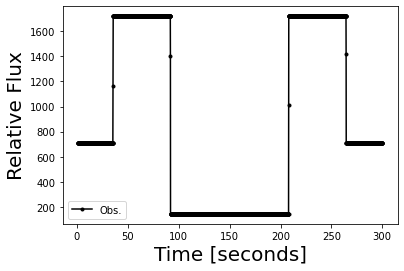

In [ ]:


#lc.normalize(flux_min=0, plot=False)
#preliminary = lc.occ_detect(plot=False)
#immersion_time = preliminary.get('immersion_time')
#emersion_time = preliminary.get('emersion_time')
#lc.occ_model(immersion_time=immersion_time, emersion_time=emersion_time,opacity =1,
#flux_min = x, flux_max = 1, mask = preliminary.get('occ_mask') )
lc.plot_lc()